In [162]:
#paquet pour la modelisation et la resolution du programme linéaire
#from mip import *
#paquet pour utiliser des structures de données plus efficaces
from matplotlib.pyplot import *
import itertools as it
import numpy as np
import random as rand
from mip import *

# Programme principal

In [163]:
class Data() :
    
    def __init__(self,data_legume,data_terrain):
        #fill legum data first
        with open(data_legume,'r') as file:
            line = file.readline()  # lit la 1ère ligne
            lineTab = line.split()
            #print(lineTab)
            self.horizon = int(lineTab[0])
            self.an = 24
            self.nblegumes = int(lineTab[1])
            self.lnumber = np.empty(self.nblegumes+2)
            self.name = []
            self.family = np.empty(self.nblegumes+2)
            self.croissance = np.empty(self.nblegumes+2,dtype = int)
            self.rest = np.empty(self.nblegumes+2,dtype = int)
            self.price = []
            for i in range(self.nblegumes):
                line = file.readline()
                lineTab = line.split()
                self.lnumber[i]=int(lineTab[0])
                #print(lineTab[1])
                self.name.append(lineTab[1])
                #print(self.name[i])
                self.family[i]=int(lineTab[2])
                self.croissance[i]=int(lineTab[3])
                self.rest[i]=int(lineTab[4])
                priceofi = []
                for j in range (self.horizon):
                    priceofi.append(float(lineTab[j+5]))
                self.price.append(priceofi)
            #ajout fertilisation 
            line = file.readline()
            lineTab=line.split()
            self.lnumber[self.nblegumes]=int(lineTab[0])
            self.name.append(lineTab[1])
            self.family[self.nblegumes]=int(lineTab[2])
            self.croissance[self.nblegumes]=int(lineTab[3])
            self.rest[self.nblegumes]=0
            self.price.append(np.zeros(self.horizon))
            #ajout jachere
            line = file.readline()
            lineTab=line.split()
            self.lnumber[self.nblegumes+1]=int(lineTab[0])
            self.name.append(lineTab[1])
            self.family[self.nblegumes+1]=int(lineTab[2])
            self.croissance[self.nblegumes+1]=int(lineTab[3])
            self.rest[self.nblegumes+1]=0
            self.price.append(np.zeros(self.horizon))
            
        #fill parcell data
        with open(data_terrain,'r') as file:
            line = file.readline()
            lineTab = line.split()
            self.nbparcelle = int(lineTab[0])
            self.pnumber=np.empty(self.nbparcelle)
            self.surface=np.empty(self.nbparcelle)
            self.nbvoisin=np.empty(self.nbparcelle,dtype = int)
            self.voisin=[]
            for i in range(self.nbparcelle):
                line = file.readline()
                lineTab = line.split()
                self.pnumber[i]=int(lineTab[0])
                self.surface[i]=float(lineTab[1])
                self.nbvoisin[i]=int(lineTab[2])
                voisin_i=[]
                for j in range(self.nbvoisin[i]):
                    voisin_i.append(int(lineTab[3+j]))
                self.voisin.append(voisin_i)
                
    def resume(self):
        print("Resume du jeu de donnée :")
        print("Notre horizon de temps est constitué de ",self.horizon," périodes.")
        print("Le terrain est composée de ",self.nbparcelle," :")
        for i in range (self.nbparcelle):
            print("  -La parcelle ",self.pnumber[i]," a une surface de ",self.surface[i],"m2 et a ",self.nbvoisin[i]," voisins : ",self.voisin[i])
        print("Nous avons ",self.nblegumes," disponibles :")
        for i in range(self.nblegumes+2):
            print("  -Le légume ",self.lnumber[i]," ",self.name[i]," est de la famille ",self.family[i], " son temps de croissance est de ",self.croissance[i]," périodes.")
            print("la terre doit se reposer ",self.rest[i]," suite a sa culture")
    def legumeInfo(self,x):
        print( self.name[x]," suit le calendrier suivant :")
        print(self.price[x])


#start model test
def build_model(Data):
    model = Model(name = "solver", solver_name=CBC)
    #creating variables
    z=[[[model.add_var(name='z'+str(p)+'_'+str(l)+'_'+str(t),var_type=BINARY) for t in range (Data.horizon) ]for l in range (Data.nblegumes+2)]for p in range (Data.nbparcelle)]
    x=[[[model.add_var(name='x'+str(p)+'_'+str(l)+'_'+str(t),var_type=BINARY) for t in range (Data.horizon) ]for l in range (Data.nblegumes+2)]for p in range (Data.nbparcelle)]
    z = np.array(z)
    x = np.array(x)
    #objective
    model.objective = maximize(xsum(z[p][l][t]*Data.surface[p]*Data.price[l][t] for p in range(Data.nbparcelle) for l in range(Data.nblegumes+2) for t in range(Data.horizon) if abs(Data.price[l][t])>1e-6 ) ) #
    #constraint
    #fertilisation
    for p in range(Data.nbparcelle):
        model.add_constr(xsum(z[p][Data.nblegumes][t] for t in range (Data.horizon)) >=1)
    #jachere
    for p in range(Data.nbparcelle):
        model.add_constr(xsum(z[p][Data.nblegumes+1][t] for t in range (Data.horizon)) >=1)
    #une parcelle ne peut pas etre occupé par plus d'un legume
    for p in range(Data.nbparcelle):
        for t in range(Data.horizon):
            model.add_constr(xsum(x[p][l][t] for l in range(Data.nblegumes+2)) <= 1)
    #adjacence
    for p in range(Data.nbparcelle):
        for pprim in Data.voisin[p]:
            for l in range(Data.nblegumes+2):
                for t in range(Data.horizon):
                    model.add_constr(xsum(x[pprim][lprim][t] for lprim in range(Data.nblegumes+2) if Data.family[lprim]==Data.family[l] and Data.lnumber[lprim] != Data.lnumber[l])  <= 1-x[p][l][t] )
    #continuite
    for p in range(Data.nbparcelle):
        for l in range(Data.nblegumes+2):
            for t in range(Data.horizon):
                model.add_constr(xsum(z[p][lprim][tprim] for lprim in range(Data.nblegumes+2) for tprim in range( (t-Data.croissance[lprim]-Data.rest[lprim]+1)%Data.horizon ,t) if Data.family[lprim]==Data.family[l] ) <= 1-z[p][l][t] )
                model.add_constr(xsum(z[p][l][tprim] for tprim in range(t-Data.croissance[l]+1,t+1))  == x[p][l][t] )                         
    return model



def model_solution(Data):
    model  = build_model(Data)
    status = model.optimize(max_seconds=300)
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(model.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(model.objective_value, model.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(model.objective_bound))
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
        solution=[]
        for p in range(Data.nbparcelle):
            for l in range(Data.nblegumes+2):
                for t in range(Data.horizon):
                    if model.vars[(Data.nblegumes+2)*Data.horizon*p+Data.horizon*l+t].x > 1e-6:
                            solution.append([p,l,t])
    return solution

class solution():
    
    def __init__(self,solution,Data):
        self.data = Data
        self.solution = solution
        
    def profits(self):
        profits = 0
        for i in self.solution:
            profits+= self.data.surface[i[0]]*self.data.price[i[1]][i[2]]
        return profits
                    
    def disp(self,details=False):
        print("Nous pouvons générer un profit de {}euro en suivant le calendrier suivant".format(self.profits()))
        print("Calendrier :")
        for i in self.solution:
            print("  Sur la parcelle {}, on plante {} à la période {}".format(i[0],self.data.name[i[1]],i[2]))
            if details==True:
                print("    -Il va l'occuper pendant {} périodes et la terre devra se reposer {} périodes".format(self.data.croissance[i[1]],self.data.rest[[i[1]]]))
            
    
    def verif (self):
        Data=self.data
        t = self.solution 
        cpt_f=np.zeros(Data.nbparcelle)
        cpt_j=np.zeros(Data.nbparcelle)
        verified = True
        for i in t:
            for j in t:
                if j!=i:
                    #continuite plus occupation
                    if i[0]==j[0]:
                        if Data.family[i[1]]==Data.family[j[1]]:
                            if i[2]<=j[2]<=i[2]+Data.croissance[i[1]]+Data.rest[i[1]]-1:
                                print("continuité pas respectée même famille")
                                print(i)
                                print(j)
                                Verified = False
                        else :
                            if i[2]<=j[2]<=i[2]+Data.croissance[i[1]]-1:
                                print("continuité pas respectée")
                                print(i)
                                print(j)
                                Verified = False
                    #voisinage
                    elif j[0] in Data.voisin[i[0]]:
                        if Data.family[j[1]]==Data.family[i[1]] and j[1]!=i[1]:
                            if i[2]<=j[2]<=i[2]+Data.croissance[2]-1:
                                print("voisinage")
                                print(i)
                                print(j)


                #fertil et jachere       
                if i[1]==Data.nblegumes:
                    cpt_f[i[0]]+=1
                if i[1]==Data.nblegumes + 1:
                    cpt_j[i[0]]+=1
        for v in range(Data.nbparcelle):
            if (cpt_f[v]<1 or cpt_j[v]<1):
                print("Jachere ferti pas faite")
                verified = False
        
        #conclusion
        if verified == True:
            print("la solution est valide")
        else:
            print("la solution n'est pas valide")
            
# Fonction permettant de connaître le légume ayant la croissance la plus courte

def croiss_min(data):
    mini = data.croissance[0]
    ind = 0
    for i in range ( 1 , data.nblegumes):
        if ( data.croissance[i]< mini ):
            mini = data.croissance[i]
            ind = i 
    return mini


# Fonction permettant de vérifier qu'on a le temps de planter sur une parcelle p dont l'occupation 
# est représentée par le tableau t un légume l à une période tps

def verif_plant( t , p ,  leg, tps , data) :
    k = data.croissance[leg]
    bool = True
    T = t[p]
    # Vérif temps de croissance libre
    if ( tps+k > data.horizon):
        bool = False
    else : 
        for i in range ( 0 , data.nblegumes+2 ):
            for j in range (tps , tps + k):
                if (T[i][j]==1):
                    bool = False
    # Vérif continuité
    LstFam=[]
    for i in range (0, data.nblegumes):
         if (data.family[leg] == data.family[i]):
            LstFam+=[i]
    if (bool==True):
        for l in (LstFam) :
            if (T[l][tps-1]==1):
                bool = False
    # Vérif Adjacence
    # On fait la liste des légumes de la même famille que l
        if (bool==True):
            for i in data.voisin[leg]:
                for l in (LstFam):
                    if t[i][l][tps]==1:
                        bool = False
    return bool

    
# Fonction créant un calendrier aléatoire respectant les contraintes

def aleatoire(data):
    #Création du tableau vide de dimension : nbparcelles * nblegumes * nb périodes
    t = [[[0 for t in range (data.horizon)] for l in range (data.nblegumes + 2)] for p in range (data.nbparcelle)]
    tz = [[[0 for t in range (data.horizon)] for l in range (data.nblegumes + 2)] for p in range (data.nbparcelle)]
    #On tire au hasard pour chaque parcelle le début de la fertilisation puis le début de la jachère
    for i in range (data.nbparcelle):
        P=[i for i in range (0, data.horizon + 1 - data.croissance[data.nblegumes+1])]
        k=rand.randint(0, (data.horizon - data.croissance[data.nblegumes]))
        for j in range ( k - data.croissance[data.nblegumes+1] + 1 , k ):
            if j in P:
                P.remove(j)
        tz [i][data.nblegumes][k] = 1
        for j in range ( k , k + data.croissance[data.nblegumes] ):
            t[i][data.nblegumes][j]=1
            if j in P:
                P.remove(j)
        k = rand.choice(P)
        tz [i][data.nblegumes+1][k] = 1
        for j in range ( k , k + data.croissance[data.nblegumes+1] ):
            t[i][data.nblegumes+1][j]=1
    LstParc = [k for k in range (data.nbparcelle)] 
    count = 0
    for k in range ( 0 , data.nbparcelle):
        # On tire au hasard une parcelle à remplir
        p = rand.choice(LstParc)
        LstParc.remove(p)
        # On remplit la parcelle p
        tps = 0
        # On passe par toutes les périodes de temps
        while (tps <= data.horizon - croiss_min(data) ):
            LstLeg = [l for l in range (data.nblegumes)]
            V = False
            while ( V == False and len(LstLeg)!=0):
                l = rand.choice(LstLeg)
                LstLeg.remove(l)
                V = verif_plant( t , p , l , tps , data)
                if ( V == True ): 
                    tz[p][l][tps]=1
                    for i in range ( tps ,  tps + data.croissance[l] ):
                        t[p][l][i]=1
            tps += 1
    return (tz)  


# Fonction calculant la rentabilité d'un calendrier

def rentabilite ( tz , datal , datat ):
    data=Data(datal,datat)
    sum = 0
    for p in range (0, len(tz)):
        for l in range (0, data.nblegumes):
            if 1 in tz[p][l] :
                for t in range (0, data.horizon):
                    sum+=data.price[l][t]
    return sum


# Fonction retournant le meilleur calendrier parmi n créés

def best_aleatoire ( datal, datat, n):
    data=Data(datal,datat)
    t = aleatoire(data)
    t2 = []
    maxi = rentabilite(t,datal,datat)
    for i in range (1,n):
        t2 = aleatoire(data)
        if ( rentabilite(t2,datal,datat) > maxi ):
            t = t2
            maxi = rentabilite (t,datal,datat)
    return (t)

# best_aleatoire(datal,datat,10)

# Transformation calendrier de z en class solution

def solutionAl(vec,Data):
    solution=[]
    for p in range(Data.nbparcelle):
        for l in range(Data.nblegumes+2):
            for t in range(Data.horizon):
                if vec[p][l][t] > 1e-6:
                        solution.append([p,l,t])
    return solution


# Fonction vérifiant la validité d'un échantillon de n calendriers aléatoires

def verif_aleatoire( n , data ):
    bool=True
    k=0
    while (bool==True and k<n):
        if (( solutionAl(aleatoire(data),data).verif ) == False):
            bool==False
        k+=1
    return bool            

# EXPÉRIMENTATION SUR L'HORIZON DE TEMPS

### Modification de l'horizon de temps d'une instance la classe data

In [170]:
def modif_horizon( datal , datat, n ):
    data = Data(datal, datat)
    data2 = Data(datal, datat)
    data2.horizon = data2.horizon * n
    for i in range ( data2.nblegumes ):
        V = data.price[i]
        for j in range (n-1):
            for k in V:
                data2.price[i]+=[k]
    data2.price[data2.nblegumes]=np.zeros(data2.horizon)
    data2.price[data2.nblegumes+1]=np.zeros(data2.horizon)
    return data2

### Méthode de résolution linéaire pour un horizon modifié ( Il fallait étendre les contraintes de jachère et de fertilisation )

In [171]:
def build_model_bis ( Data , n):
    model = Model(name = "solver", solver_name=CBC)
    #creating variables
    z=[[[model.add_var(name='z'+str(p)+'_'+str(l)+'_'+str(t),var_type=BINARY) for t in range (Data.horizon) ]for l in range (Data.nblegumes+2)]for p in range (Data.nbparcelle)]
    x=[[[model.add_var(name='x'+str(p)+'_'+str(l)+'_'+str(t),var_type=BINARY) for t in range (Data.horizon) ]for l in range (Data.nblegumes+2)]for p in range (Data.nbparcelle)]
    z = np.array(z)
    x = np.array(x)
    #objective
    model.objective = maximize(xsum(z[p][l][t]*Data.surface[p]*Data.price[l][t] for p in range(Data.nbparcelle) for l in range(Data.nblegumes+2) for t in range(Data.horizon) if (abs(Data.price[l][t])>1e-6) ) ) 
    #constraint
    #fertilisation
    for p in range(Data.nbparcelle):
        for k in range (0,n):
            model.add_constr(xsum(z[p][Data.nblegumes][t] for t in range (k*(Data.an),(k+1)*24)) >=1)
    #jachere
    for p in range(Data.nbparcelle):
        for k in range (0,n):
            model.add_constr(xsum(z[p][Data.nblegumes+1][t] for t in range (k*(Data.an),(k+1)*24)) >=1)
    #une parcelle ne peut pas etre occupé par plus d'un legume
    for p in range(Data.nbparcelle):
        for t in range(Data.horizon):
            model.add_constr(xsum(x[p][l][t] for l in range(Data.nblegumes+2)) <= 1)
    #adjacence
    for p in range(Data.nbparcelle):
        for pprim in Data.voisin[p]:
            for l in range(Data.nblegumes+2):
                for t in range(Data.horizon):
                    model.add_constr(xsum(x[pprim][lprim][t] for lprim in range(Data.nblegumes+2) if Data.family[lprim]==Data.family[l] and Data.lnumber[lprim] != Data.lnumber[l])  <= 1-x[p][l][t] )
    #continuite
    for p in range(Data.nbparcelle):
        for l in range(Data.nblegumes+2):
            for t in range(Data.horizon):
                model.add_constr(xsum(z[p][lprim][tprim] for lprim in range(Data.nblegumes+2) for tprim in range( (t-Data.croissance[lprim]-Data.rest[lprim]+1)%Data.horizon ,t) if Data.family[lprim]==Data.family[l] ) <= 1-z[p][l][t] )
                model.add_constr(xsum(z[p][l][tprim] for tprim in range(t-Data.croissance[l]+1,t+1))  == x[p][l][t] )                        
    return model


def model_solution_bis( Data , n):
    model  = build_model_bis(Data , n)
    status = model.optimize(max_seconds=300)
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(model.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(model.objective_value, model.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(model.objective_bound))
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
        solution=[]
        for p in range(Data.nbparcelle):
            for l in range(Data.nblegumes+2):
                for t in range(Data.horizon):
                    if model.vars[(Data.nblegumes+2)*Data.horizon*p+Data.horizon*l+t].x > 1e-6:
                            solution.append([p,l,t])
    return solution

### Programme déterminant le calendrier optimal pour un horizon multiplié par n

In [172]:
def solution_horizon( datal, datat , n ):
    data = modif_horizon( datal, datat , n )
    solution = model_solution_bis(data,n)
    return solution

### Renvoie un graphe représentant le profit optimal par an en fonction du nombre d'années de l'horizon

In [173]:
def convergence_solution_horizon ( datal , datat , n ):
    V=[]
    for i in range (1, n+1):
        sol = model_solution_bis(modif_horizon(datal,datat,i),i)
        S = solution ( sol , modif_horizon(datal,datat,i))
        V.append(S.profits()/i)
    T=[k for k in range (1,n+1)]
    matplotlib.pyplot.plot(T,V)

### On trace le graphe pour 15 ans

Cgl0003I 0 fixed, 0 tightened bounds, 2655 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2655 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2177 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1325 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 967 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 537 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 227 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 28 strengthened rows, 0 substitutions
Cgl0004I processed model has 1944 rows, 2700 columns (2700 integer (2700 of which binary)) and 12777 elements
Coin3009W Conflict graph built in 0.003 seconds, density: 0.115%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 371 integers unsatisfied sum - 174.5
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. -2.14418e+06 iterations 1751
C

optimal solution cost 284250.0 found
Cgl0003I 0 fixed, 0 tightened bounds, 252 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 252 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 207 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 123 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 94 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 52 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 189 rows, 270 columns (270 integer (270 of which binary)) and 1248 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 1.140%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 33 integers unsatisfied sum - 16.5
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. -224700 

optimal solution cost 566250.0 found
Cgl0003I 0 fixed, 0 tightened bounds, 519 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 519 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 426 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 256 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 193 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 105 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 48 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0004I processed model has 384 rows, 540 columns (540 integer (540 of which binary)) and 2529 elements
Coin3009W Conflict graph built in 0.001 seconds, density: 0.571%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 66 integers unsatisfied sum - 33
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. -432000 

Coin0506I Presolve 1020 (-2814) rows, 810 (-1350) columns and 3798 (-4737) elements
Clp1000I sum of infeasibilities 4.97671e-07 - average 4.87912e-10, 432 fixed columns
Coin0506I Presolve 450 (-570) rows, 378 (-432) columns and 1332 (-2466) elements
Clp0006I 0  Obj 920249.99 Dual inf 20362.5 (234)
Clp0029I End of values pass after 378 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000001 - largest nonzero change 2.8913165e-05 ( 0.0014456583%) - largest zero change 2.9278563e-05
Clp0000I Optimal - objective value 920250
Clp0000I Optimal - objective value 920250
Coin0511I After Postsolve, objective 920250, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 920250 Dual inf 439762.5 (150)
Clp0014I Perturbing problem by 0.001% of 1.0000001 - largest nonzero change 2.9936919e-05 ( 0.0014968459%) - largest zero change 2.8656153e-05
Clp0000I Optimal - objective value 920250
Clp0000I Optimal - objective value 920250
Clp0000I Optimal - objective value 920250
Coin0511I After Posts

optimal solution cost 1134000.0 found
Cgl0003I 0 fixed, 0 tightened bounds, 1053 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1053 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 863 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 524 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 388 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 212 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 96 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0004I processed model has 774 rows, 1080 columns (1080 integer (1080 of which binary)) and 5091 elements
Coin3009W Conflict graph built in 0.001 seconds, density: 0.286%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 172 integers unsatisfied sum - 78.3333
Cbc0038I Pass   1: suminf.    0.00000 (0) 

Coin0506I Presolve 1710 (-4680) rows, 1350 (-2250) columns and 6354 (-7893) elements
Clp1000I sum of infeasibilities 9.09901e-07 - average 5.32106e-10, 720 fixed columns
Coin0506I Presolve 750 (-960) rows, 630 (-720) columns and 2220 (-4134) elements
Clp0006I 0  Obj 1533750 Dual inf 33937.5 (390)
Clp0029I End of values pass after 630 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000001 - largest nonzero change 2.9976735e-05 ( 0.0014988367%) - largest zero change 2.9394864e-05
Clp0000I Optimal - objective value 1533750
Clp0000I Optimal - objective value 1533750
Coin0511I After Postsolve, objective 1533750, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 1533750 Dual inf 821062.5 (263)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9936918e-05 ( 0.0014968459%) - largest zero change 2.982246e-05
Clp0000I Optimal - objective value 1533750
Clp0000I Optimal - objective value 1533750
Clp0000I Optimal - objective value 1533750
Coin0511I After Postsolv

Coin0506I Presolve 2055 (-5613) rows, 1620 (-2700) columns and 7632 (-9471) elements
Clp1000I sum of infeasibilities 1.06876e-06 - average 5.2008e-10, 864 fixed columns
Coin0506I Presolve 900 (-1155) rows, 756 (-864) columns and 2664 (-4968) elements
Clp0006I 0  Obj 1840500 Dual inf 40725 (468)
Clp0029I End of values pass after 756 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000001 - largest nonzero change 2.9976734e-05 ( 0.0014988367%) - largest zero change 2.982246e-05
Clp0000I Optimal - objective value 1840500
Clp0000I Optimal - objective value 1840500
Coin0511I After Postsolve, objective 1840500, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 1840500 Dual inf 920512.5 (297)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9976734e-05 ( 0.0014988367%) - largest zero change 2.9669812e-05
Clp0000I Optimal - objective value 1840500
Clp0000I Optimal - objective value 1840500
Clp0000I Optimal - objective value 1840500
Coin0511I After Postsolve,

Coin0506I Presolve 2400 (-6546) rows, 1890 (-3150) columns and 8910 (-11049) elements
Clp1000I sum of infeasibilities 1.25192e-06 - average 5.21634e-10, 1008 fixed columns
Coin0506I Presolve 1050 (-1350) rows, 882 (-1008) columns and 3108 (-5802) elements
Clp0006I 0  Obj 2147250 Dual inf 47512.499 (546)
Clp0029I End of values pass after 882 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000001 - largest nonzero change 2.9868801e-05 ( 0.0014934401%) - largest zero change 2.9605685e-05
Clp0000I Optimal - objective value 2147250
Clp0000I Optimal - objective value 2147250
Coin0511I After Postsolve, objective 2147250, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 2147250 Dual inf 1001400 (333)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9868801e-05 ( 0.00149344%) - largest zero change 2.9976734e-05
Clp0000I Optimal - objective value 2147250
Clp0000I Optimal - objective value 2147250
Clp0000I Optimal - objective value 2147250
Coin0511I After Pos

Coin0506I Presolve 2745 (-7479) rows, 2160 (-3600) columns and 10188 (-12627) elements
Clp1000I sum of infeasibilities 1.43044e-06 - average 5.21106e-10, 1152 fixed columns
Coin0506I Presolve 1200 (-1545) rows, 1008 (-1152) columns and 3552 (-6636) elements
Clp0006I 0  Obj 2454000 Dual inf 54299.999 (624)
Clp0029I End of values pass after 1008 iterations
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9868801e-05 ( 0.0014934401%) - largest zero change 2.9976734e-05
Clp0000I Optimal - objective value 2454000
Clp0000I Optimal - objective value 2454000
Coin0511I After Postsolve, objective 2454000, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 2454000 Dual inf 1394250 (423)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9943246e-05 ( 0.0014971623%) - largest zero change 2.9605685e-05
Clp0000I Optimal - objective value 2454000
Clp0000I Optimal - objective value 2454000
Clp0000I Optimal - objective value 2454000
Coin0511I After Postso

Cbc0010I After 1224 nodes, 11 on tree, -2266500 best solution, best possible -2266890.2 (52.49 seconds)
Cbc0010I After 1257 nodes, 4 on tree, -2266500 best solution, best possible -2266890.2 (53.35 seconds)
Cbc0010I After 1277 nodes, 24 on tree, -2266500 best solution, best possible -2266890.2 (54.05 seconds)
Cbc0038I Full problem 1554 rows 2160 columns, reduced to 372 rows 320 columns
Cbc0010I After 1324 nodes, 19 on tree, -2266500 best solution, best possible -2266890.2 (54.76 seconds)
Cbc0010I After 1367 nodes, 22 on tree, -2266500 best solution, best possible -2266890.2 (55.46 seconds)
Cbc0010I After 1424 nodes, 21 on tree, -2266500 best solution, best possible -2266890.2 (56.16 seconds)
Cbc0010I After 1464 nodes, 21 on tree, -2266500 best solution, best possible -2266890.2 (56.88 seconds)
Cbc0010I After 1513 nodes, 24 on tree, -2266500 best solution, best possible -2266890.2 (57.58 seconds)
Cbc0010I After 1572 nodes, 24 on tree, -2266500 best solution, best possible -2266890.2 (58

Cbc0010I After 5478 nodes, 4 on tree, -2266500 best solution, best optimal solution cost 2266500.0 found
possible -2266858.1 (166.93 seconds)
Cbc0001I Search completed - best objective -2266500, took 283125 iterations and 5504 nodes (167.56 seconds)
Cbc0032I Strong branching done 7586 times (63235 iterations), fathomed 77 nodes and fixed 24 variables
Cbc0035I Maximum depth 35, 59399 variables fixed on reduced cost
Total time (CPU seconds):       145.26   (Wallclock seconds):       168.29

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 3090 (-8412) rows, 2430 (-4050) columns and 11466 (-14205) elements
Clp1000I sum of infeasibilities 1.60458e-06 - average 5.19282e-10, 1296 fixed columns
Coin0506I Presolve 1350 (-1740) rows, 1134 (-1296) columns and 3996 (-7470) elements
Clp0006I 0  Obj 2760750 Dual inf 61087.499 (702)
Clp0029I End of values pass after 1134 iterations
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero cha

Coin0506I Presolve 3435 (-9345) rows, 2700 (-4500) columns and 12744 (-15783) elements
Clp1000I sum of infeasibilities 1.80183e-06 - average 5.24551e-10, 1440 fixed columns
Coin0506I Presolve 1500 (-1935) rows, 1260 (-1440) columns and 4440 (-8304) elements
Clp0006I 0  Obj 3067500 Dual inf 67874.999 (780)
Clp0029I End of values pass after 1260 iterations
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.99148e-05 ( 0.00149574%) - largest zero change 2.9819115e-05
Clp0000I Optimal - objective value 3067500
Clp0000I Optimal - objective value 3067500
Coin0511I After Postsolve, objective 3067500, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 3067500 Dual inf 1622700 (518)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9928247e-05 ( 0.0014964124%) - largest zero change 2.9793676e-05
Clp0000I Optimal - objective value 3067500
Clp0000I Optimal - objective value 3067500
Clp0000I Optimal - objective value 3067500
Coin0511I After Postsolve,

Coin0506I Presolve 3780 (-10278) rows, 2970 (-4950) columns and 14022 (-17361) elements
Clp1000I sum of infeasibilities 1.92373e-06 - average 5.08923e-10, 1584 fixed columns
Coin0506I Presolve 1650 (-2130) rows, 1386 (-1584) columns and 4884 (-9138) elements
Clp0006I 0  Obj 3374249.9 Dual inf 74662.499 (858)
Clp0029I End of values pass after 1386 iterations
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.99148e-05 ( 0.00149574%) - largest zero change 2.9936918e-05
Clp0000I Optimal - objective value 3374250
Clp0000I Optimal - objective value 3374250
Coin0511I After Postsolve, objective 3374250, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 3374250 Dual inf 1757250 (567)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9943246e-05 ( 0.0014971623%) - largest zero change 2.9936918e-05
Clp0000I Optimal - objective value 3374250
Clp0000I Optimal - objective value 3374250
Clp0000I Optimal - objective value 3374250
Coin0511I After Postsol

Cbc0010I After 1180 nodes, 78 on tree, -3115650 best solution, best possible -3117418.1 (106.47 seconds)
Cbc0038I Full problem 2139 rows 2970 columns, reduced to 930 rows 753 columns
Cbc0010I After 1203 nodes, 78 on tree, -3115650 best solution, best possible -3117418.1 (107.25 seconds)
Cbc0010I After 1239 nodes, 90 on tree, -3115650 best solution, best possible -3117418.1 (107.95 seconds)
Cbc0010I After 1284 nodes, 84 on tree, -3115650 best solution, best possible -3117418.1 (108.65 seconds)
Cbc0038I Full problem 2139 rows 2970 columns, reduced to 355 rows 312 columns
Cbc0010I After 1319 nodes, 82 on tree, -3115650 best solution, best possible -3117418.1 (109.40 seconds)
Cbc0010I After 1357 nodes, 85 on tree, -3115650 best solution, best possible -3117418.1 (110.11 seconds)
Cbc0010I After 1395 nodes, 81 on tree, -3115650 best solution, best possible -3117418.1 (110.82 seconds)
Cbc0038I Full problem 2139 rows 2970 columns, reduced to 607 rows 507 columns
Cbc0010I After 1422 nodes, 79 o

Cbc0010I After 5357 nodes, 15 on tresol.cost 3115950.0 found, best possible: 3117418.1125982427
e, -3115650 best solution, best possible -3117418.1 (215.12 seconds)
Cbc0010I After 5385 nodes, 19 on tree, -3115650 best solution, best possible -3117418.1 (215.85 seconds)
Cbc0038I Full problem 2139 rows 2970 columns, reduced to 572 rows 512 columns
Cbc0010I After 5419 nodes, 15 on tree, -3115650 best solution, best possible -3117418.1 (216.57 seconds)
Cbc0010I After 5442 nodes, 23 on tree, -3115650 best solution, best possible -3117418.1 (217.33 seconds)
Cbc0010I After 5482 nodes, 22 on tree, -3115650 best solution, best possible -3117418.1 (218.04 seconds)
Cbc0010I After 5507 nodes, 20 on tree, -3115650 best solution, best possible -3117418.1 (218.76 seconds)
Cbc0010I After 5537 nodes, 17 on tree, -3115650 best solution, best possible -3117418.1 (219.47 seconds)
Cbc0010I After 5560 nodes, 20 on tree, -3115650 best solution, best possible -3117418.1 (220.20 seconds)
Cbc0010I After 5578 no

Coin0506I Presolve 4125 (-11211) rows, 3240 (-5400) columns and 15300 (-18939) elements
Clp1000I sum of infeasibilities 2.08978e-06 - average 5.06613e-10, 1728 fixed columns
Coin0506I Presolve 1800 (-2325) rows, 1512 (-1728) columns and 5328 (-9972) elements
Clp0006I 0  Obj 3680999.9 Dual inf 81449.999 (936)
Clp0029I End of values pass after 1512 iterations
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9693114e-05 ( 0.0014846557%) - largest zero change 2.9819115e-05
Clp0000I Optimal - objective value 3681000
Clp0000I Optimal - objective value 3681000
Coin0511I After Postsolve, objective 3681000, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 3681000 Dual inf 1854675 (601)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9907206e-05 ( 0.0014953603%) - largest zero change 2.9976734e-05
Clp0000I Optimal - objective value 3681000
Clp0000I Optimal - objective value 3681000
Clp0000I Optimal - objective value 3681000
Coin0511I After Pos

Cbc0010I After 1839 nodes, 83 on tree, -3397425 best solution, best possible -3401013.4 (57.77 seconds)
Cbc0010I After 1876 nodes, 75 on tree, -3397425 best solution, best possible -3401013.4 (58.47 seconds)
Cbc0010I After 1912 nodes, 74 on tree, -3397425 best solution, best possible -3401013.4 (59.19 seconds)
Cbc0010I After 1949 nodes, 69 on tree, -3397425 best solution, best possible -3401013.4 (59.91 seconds)
Cbc0010I After 1981 nodes, 67 on tree, -3397425 best solution, best possible -3401013.4 (60.64 seconds)
Cbc0010I After 2018 nodes, 71 on tree, -3397425 best solution, best possible -3401013.4 (61.36 seconds)
Cbc0010I After 2064 nodes, 68 on tree, -3397425 best solution, best possible -3401013.4 (62.06 seconds)
Cbc0010I After 2103 nodes, 68 on tree, -3397425 best solution, best possible -3401013.4 (62.80 seconds)
Cbc0010I After 2139 nodes, 64 on tree, -3397425 best solution, best possible -3401013.4 (63.50 seconds)
Cbc0010I After 2187 nodes, 59 on tree, -3397425 best solution, b

Cbc0010I After 5850 nodes, 81 on tree, -3399525 best solution, best possible -3401013.4 (165.85 seconds)
Cbc0010I After 5873 nodes, 88 on tree, -3399525 best solution, best possible -3401013.4 (166.55 seconds)
Cbc0010I After 5906 nodes, 88 on tree, -3399525 best solution, best possible -3401013.4 (167.25 seconds)
Cbc0010I After 5941 nodes, 84 on tree, -3399525 best solution, best possible -3401013.4 (167.95 seconds)
Cbc0010I After 5965 nodes, 88 on tree, -3399525 best solution, best possible -3401013.4 (168.66 seconds)
Cbc0010I After 5987 nodes, 93 on tree, -3399525 best solution, best possible -3401013.4 (169.36 seconds)
Cbc0038I Full problem 2334 rows 3240 columns, reduced to 963 rows 773 columns
Cbc0010I After 6009 nodes, 96 on tree, -3399525 best solution, best possible -3401013.4 (170.08 seconds)
Cbc0010I After 6044 nodes, 95 on tree, -3399525 best solution, best possible -3401013.4 (170.79 seconds)
Cbc0010I After 6078 nodes, 95 on tree, -3399525 best solution, best possible -3401

Cbc0010I Aftersol.cost 3399750.0 found, best possible: 3401013.3780283723
 9881 nodes, 13 on tree, -3399750 best solution, best possible -3401013.4 (279.00 seconds)
Cbc0010I After 9902 nodes, 12 on tree, -3399750 best solution, best possible -3401013.4 (279.70 seconds)
Cbc0010I After 9922 nodes, 10 on tree, -3399750 best solution, best possible -3401013.4 (280.40 seconds)
Cbc0010I After 9947 nodes, 10 on tree, -3399750 best solution, best possible -3401013.4 (281.13 seconds)
Cbc0010I After 9969 nodes, 11 on tree, -3399750 best solution, best possible -3401013.4 (281.83 seconds)
Cbc0010I After 9988 nodes, 13 on tree, -3399750 best solution, best possible -3401013.4 (282.58 seconds)
Cbc0010I After 10006 nodes, 3 on tree, -3399750 best solution, best possible -3401013.4 (283.62 seconds)
Cbc0010I After 10009 nodes, 6 on tree, -3399750 best solution, best possible -3401013.4 (284.51 seconds)
Cbc0010I After 10018 nodes, 8 on tree, -3399750 best solution, best possible -3401013.4 (285.23 seco

Cbc0010I After 2038 nodes, 31 on tree, -3682650 best solution, best possible -3685598.5 (81.34 seconds)
Cbc0010I After 2050 nodes, 37 on tree, -3682650 best solution, best possible -3685598.5 (82.05 seconds)
Cbc0010I After 2066 nodes, 38 on tree, -3682650 best solution, best possible -3685598.5 (82.81 seconds)
Cbc0010I After 2086 nodes, 43 on tree, -3682650 best solution, best possible -3685598.5 (83.52 seconds)
Cbc0010I After 2109 nodes, 45 on tree, -3682650 best solution, best possible -3685598.5 (84.28 seconds)
Cbc0010I After 2127 nodes, 48 on tree, -3682650 best solution, best possible -3685598.5 (84.99 seconds)
Cbc0010I After 2151 nodes, 44 on tree, -3682650 best solution, best possible -3685598.5 (85.70 seconds)
Cbc0010I After 2173 nodes, 42 on tree, -3682650 best solution, best possible -3685598.5 (86.43 seconds)
Cbc0010I After 2196 nodes, 47 on tree, -3682650 best solution, best possible -3685598.5 (87.16 seconds)
Cbc0010I After 2217 nodes, 54 on tree, -3682650 best solution, b

Cbc0010I After 5535 noptimal solution cost 3683250.0 found
odes, 5 on tree, -3683250 best solution, best possible -3684232.3 (196.79 seconds)
Cbc0010I After 5541 nodes, 3 on tree, -3683250 best solution, best possible -3684232.3 (197.61 seconds)
Cbc0010I After 5543 nodes, 5 on tree, -3683250 best solution, best possible -3684232.3 (198.60 seconds)
Cbc0010I After 5556 nodes, 9 on tree, -3683250 best solution, best possible -3684232.3 (199.33 seconds)
Cbc0010I After 5573 nodes, 9 on tree, -3683250 best solution, best possible -3684232.3 (200.14 seconds)
Cbc0010I After 5587 nodes, 7 on tree, -3683250 best solution, best possible -3684232.3 (200.95 seconds)
Cbc0010I After 5606 nodes, 6 on tree, -3683250 best solution, best possible -3684232.3 (201.69 seconds)
Cbc0010I After 5622 nodes, 7 on tree, -3683250 best solution, best possible -3684232.3 (202.47 seconds)
Cbc0010I After 5646 nodes, 8 on tree, -3683250 best solution, best possible -3684232.3 (203.42 seconds)
Cbc0010I After 5659 nodes,

Cbc0010I After 2141 nodes, 117 on tree, -3966000 best solution, best possible -3967413.7 (79.58 seconds)
Cbc0010I After 2175 nodes, 113 on tree, -3966000 best solution, best possible -3967413.7 (80.30 seconds)
Cbc0010I After 2209 nodes, 110 on tree, -3966000 best solution, best possible -3967413.7 (81.02 seconds)
Cbc0010I After 2242 nodes, 103 on tree, -3966000 best solution, best possible -3967413.7 (81.73 seconds)
Cbc0010I After 2266 nodes, 101 on tree, -3966000 best solution, best possible -3967413.7 (82.45 seconds)
Cbc0010I After 2301 nodes, 100 on tree, -3966000 best solution, best possible -3967413.7 (83.18 seconds)
Cbc0010I After 2331 nodes, 98 on tree, -3966000 best solution, best possible -3967413.7 (83.90 seconds)
Cbc0010I After 2358 nodes, 96 on tree, -3966000 best solution, best possible -3967413.7 (84.64 seconds)
Cbc0010I After 2385 nodes, 98 on tree, -3966000 best solution, best possible -3967413.7 (85.35 seconds)
Cbc0038I Full problem 2724 rows 3780 columns, reduced to 9

Cbc0010I After 6036 nodes, 45 on tree, -3966000 best solution, best possible -39sol.cost 3966000.0 found, best possible: 3967413.6937345928
67413.7 (190.80 seconds)
Cbc0010I After 6058 nodes, 46 on tree, -3966000 best solution, best possible -3967413.7 (191.57 seconds)
Cbc0010I After 6082 nodes, 60 on tree, -3966000 best solution, best possible -3967413.7 (192.34 seconds)
Cbc0010I After 6112 nodes, 46 on tree, -3966000 best solution, best possible -3967413.7 (193.06 seconds)
Cbc0010I After 6144 nodes, 51 on tree, -3966000 best solution, best possible -3967413.7 (193.76 seconds)
Cbc0010I After 6167 nodes, 45 on tree, -3966000 best solution, best possible -3967413.7 (194.52 seconds)
Cbc0010I After 6190 nodes, 54 on tree, -3966000 best solution, best possible -3967413.7 (195.23 seconds)
Cbc0010I After 6219 nodes, 41 on tree, -3966000 best solution, best possible -3967413.7 (196.02 seconds)
Cbc0010I After 6241 nodes, 51 on tree, -3966000 best solution, best possible -3967413.7 (196.73 seco

Coin0506I Presolve 5160 (-14010) rows, 4050 (-6750) columns and 19134 (-23673) elements
Clp1000I sum of infeasibilities 2.56264e-06 - average 4.96636e-10, 2160 fixed columns
Coin0506I Presolve 2250 (-2910) rows, 1890 (-2160) columns and 6660 (-12474) elements
Clp0006I 0  Obj 4601249.9 Dual inf 101812.5 (1170)
Clp0029I End of values pass after 1890 iterations
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9928247e-05 ( 0.0014964124%) - largest zero change 2.9936918e-05
Clp0000I Optimal - objective value 4601250
Clp0000I Optimal - objective value 4601250
Coin0511I After Postsolve, objective 4601250, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 4601250 Dual inf 2379750 (752)
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9988748e-05 ( 0.0014994374%) - largest zero change 2.9793676e-05
Clp0000I Optimal - objective value 4601250
Clp0000I Optimal - objective value 4601250
Clp0000I Optimal - objective value 4601250
Coin0511I After Po

Cbc0010I After 411 nodes, 157 on tree, -4248750 best solution, best possible -4251537.1 (51.39 seconds)
Cbc0010I After 430 nodes, 163 on tree, -4248750 best solution, best possible -4251537.1 (52.12 seconds)
Cbc0010I After 444 nodes, 167 on tree, -4248750 best solution, best possible -4251537.1 (52.82 seconds)
Cbc0010I After 461 nodes, 172 on tree, -4248750 best solution, best possible -4251537.1 (53.53 seconds)
Cbc0010I After 480 nodes, 178 on tree, -4248750 best solution, best possible -4251537.1 (54.64 seconds)
Cbc0010I After 487 nodes, 182 on tree, -4248750 best solution, best possible -4251537.1 (55.48 seconds)
Cbc0010I After 499 nodes, 185 on tree, -4248750 best solution, best possible -4251537.1 (56.20 seconds)
Cbc0038I Full problem 2919 rows 4050 columns, reduced to 764 rows 625 columns
Cbc0010I After 513 nodes, 190 on tree, -4248750 best solution, best possible -4251537.1 (56.92 seconds)
Cbc0010I After 540 nodes, 200 on tree, -4248750 best solution, best possible -4251537.1 (5

Cbc0010I After 3457 nodes, 203 on tree, -4249500 best solution, best possible -4251537.1 (156.03 seconds)
Cbc0010I After 3483 nodes, 200 on tree, -4249500 best solution, best possible -4251537.1 (156.76 seconds)
Cbc0010I After 3507 nodes, 198 on tree, -4249500 best solution, best possible -4251537.1 (157.46 seconds)
Cbc0010I After 3525 nodes, 197 on tree, -4249500 best solution, best possible -4251537.1 (158.17 seconds)
Cbc0010I After 3545 nodes, 202 on tree, -4249500 best solution, best possible -4251537.1 (158.88 seconds)
Cbc0010I After 3561 nodes, 205 on tree, -4249500 best solution, best possible -4251537.1 (159.66 seconds)
Cbc0010I After 3581 nodes, 198 on tree, -4249500 best solution, best possible -4251537.1 (160.37 seconds)
Cbc0038I Full problem 2919 rows 4050 columns, reduced to 941 rows 762 columns
Cbc0010I After 3600 nodes, 205 on tree, -4249500 best solution, best possible -4251537.1 (161.36 seconds)
Cbc0010I After 3624 nodes, 201 on tree, -4249500 best solution, best possi

Cbc0010I After 6951 nodes, 99 on tree, -4249500 best solution, best possible -4251537.1 (26sol.cost 4249500.0 found, best possible: 4251537.124741856


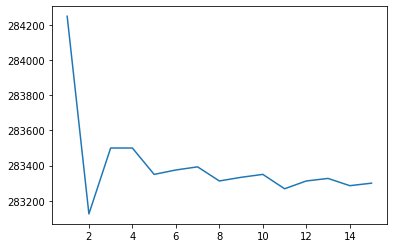

In [178]:
datat="Expériences/data_terrain_petit.txt"
datal="Expériences/data_legumes_petit.txt"
data=Data(datal,datat)

# convergence_solution_horizon( datal, datat, 15)